In [11]:
import tensorflow as tf
import numpy as np
from IPython import display
from pathlib import Path

from lib.data import SequenceGenerator
from lib.image import write_png

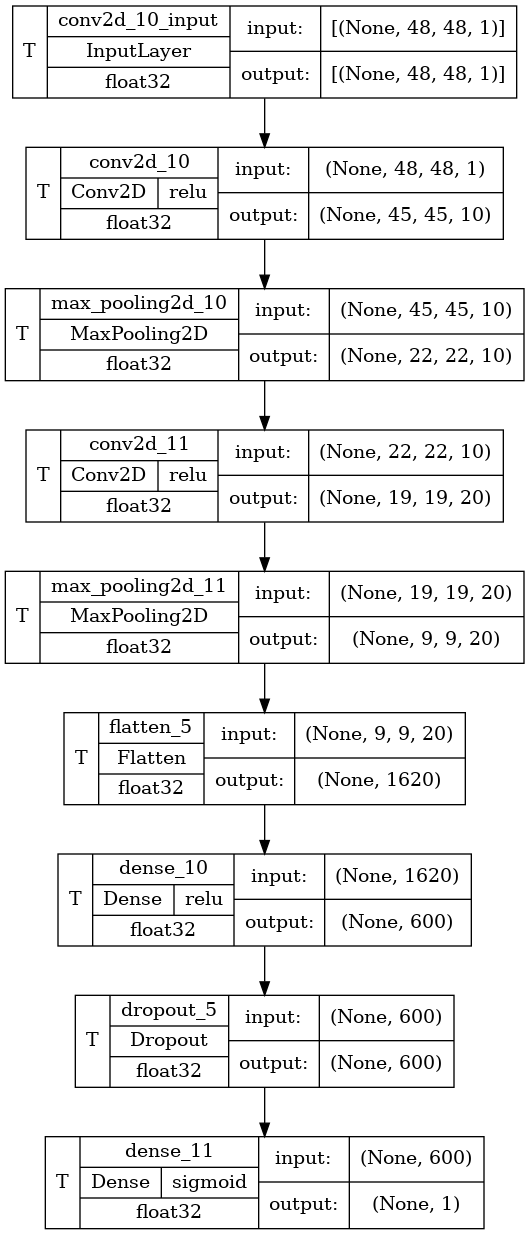

In [24]:
box_size = 48

dropout = tf.keras.layers.Dropout(0.8)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(20, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(600, activation='relu'),
  dropout,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]
              )

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)
display.Image(f'model.png')

In [47]:
gen = SequenceGenerator('img/project-1-at-2023-04-26-18-24-a552911a.json', 'img/raw')
train_data = gen.create_sequence(16, False)
validation_data = gen.create_sequence(512, True)


In [52]:
import datetime

model.optimizer.learning_rate = 0.00005
dropout.rate = 0.99

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(x=train_data,
          epochs=20,
          validation_data=validation_data,
          callbacks=[tensorboard_callback])

Epoch 1/20
  1/470 [..............................] - ETA: 47s - loss: 2.5255e-05 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00

2023-04-26 20:35:23.542894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


469/470 [============================>.] - ETA: 0s - loss: 5.9359e-04 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00

2023-04-26 20:35:42.837298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


470/470 [==============================] - 20s 42ms/step - loss: 5.9232e-04 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00 - val_loss: 0.0167 - val_binary_accuracy: 0.9956 - val_false_negatives_5: 2.0000 - val_false_positives_5: 5.0000
Epoch 2/20
470/470 [==============================] - 23s 48ms/step - loss: 5.2755e-04 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00 - val_loss: 0.0173 - val_binary_accuracy: 0.9950 - val_false_negatives_5: 2.0000 - val_false_positives_5: 6.0000
Epoch 3/20
470/470 [==============================] - 23s 50ms/step - loss: 5.9412e-04 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00 - val_loss: 0.0181 - val_binary_accuracy: 0.9943 - val_false_negatives_5: 2.0000 - val_false_positives_5: 7.0000
Epoch 4/20
470/470 [==============================] - 21s 44ms/step - loss: 4.9516e-04 - binary_accuracy: 1.0000 - false_negatives_5: 0.0000e

In [56]:
model.save_weights('model.tf')
model.save('model-all')

2023-04-26 21:08:02.222948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,600]
	 [[{{node inputs}}]]
2023-04-26 21:08:02.561057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,600]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model-all/assets


INFO:tensorflow:Assets written to: model-all/assets


In [31]:
model.load_weights('model.tf')

In [57]:
model = tf.keras.models.load_model('model-all')

In [58]:
for i in range(len(validation_data)):
    batch_x, batch_y = validation_data[i]
    batch_r = model(batch_x)
    for k in range(len(batch_x)):
        y = round(float(batch_y[k]))
        r = round(float(batch_r[k]))
        if y != r:
            offset = i * validation_data.batch_items + k // 8
            data = validation_data.data[offset]
            image_data = validation_data.images[data[0]]
            name = f'./tmp/{r}-{y}--{i}-{k}--{data[1]}x{data[2]}.png'
            print(name, image_data.info.file, image_data.info.slice_index)
            write_png(name, batch_x[k])


./tmp/1-0--0-71--1166x449.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/0-1--0-96--764x566.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/0-1--0-98--764x566.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/1-0--1-65--936x1018.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/1-0--1-67--936x1018.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/1-0--1-70--936x1018.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
./tmp/1-0--1-71--936x1018.png img/raw/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw.gz 0
(48, 48)
